In [1]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
import pydicom
import numpy as np
from torchvision import transforms
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
device = torch.device("cpu")

patient dicomdataset connects the dna to the images so we dont have to later

notice it has a structure of images,patient_id,gene_values, correponding genes

corresponding genes is purely informational, gene values are the y values per say, what we are trying to predict, paitent_id is the patient_id and images are a list of images we will use as multimodal input to discover/predict r values

the .dcm ended up being too many images for multimodal analysis. For my GPU anyway lol. So am satisfysing with just 32 high resolution images.

In [2]:

from helper import PatientDicomDataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
if not os.path.exists('data/Images/NSCLC Radiogenomics'):
         raise FileNotFoundError("The directory 'data/Images/NSCLC Radiogenomics' does not exist.")
if not os.path.exists('data/df_zscore.csv'):
         raise FileNotFoundError("The file 'data/df_zscore.csv' does not exist.")
# Verify that the dataset is properly loaded
dataset = PatientDicomDataset(root_dir='data/Images/NSCLC Radiogenomics', csv_path='data/df_zscore.csv', transform=transform)

# Check the length of the dataset to ensure it is not empty
if len(dataset) == 0:
    raise ValueError("The dataset is empty. Please check the root_dir and csv_path for correctness.")


images, patient_id, gene_values, gene_names = dataset[0]
print("Image tensor shape:", images[0].shape)

Loading CSV and images...
Image tensor shape: torch.Size([1, 224, 224])


split into training, validation and test sets

In [3]:
from torch.utils.data import random_split

# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 91
Validation set size: 19
Test set size: 20


MedicalImageCNN	Per-image encoder → [B, 1, H, W] → [B, emb_dim]
CNNToRNA	Aggregates per-patient images and predicts RNA expression
train_loader	Should return [B, N, 1, H, W], [B, num_genes]

In [4]:
#check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Epoch [1/50]


Train Loss: 0.9565 | Val Loss: 0.9833

Epoch [2/50]


Train Loss: 0.9523 | Val Loss: 0.9863

Epoch [3/50]


Train Loss: 0.9473 | Val Loss: 0.9906

Epoch [4/50]


Train Loss: 0.9272 | Val Loss: 0.9937

Epoch [5/50]


Train Loss: 0.9149 | Val Loss: 0.9784

Epoch [6/50]


Train Loss: 0.9176 | Val Loss: 0.9811

Epoch [7/50]


Train Loss: 0.9083 | Val Loss: 0.9686

Epoch [8/50]


Train Loss: 0.9081 | Val Loss: 0.9674

Epoch [9/50]


Train Loss: 0.9031 | Val Loss: 0.9924

Epoch [10/50]


Train Loss: 0.9061 | Val Loss: 0.9955

Epoch [11/50]


Train Loss: 0.8987 | Val Loss: 0.9831

Epoch [12/50]


Train Loss: 0.8943 | Val Loss: 0.9822

Epoch [13/50]


Train Loss: 0.8943 | Val Loss: 0.9701
⏹️ Early stopping triggered at epoch 13


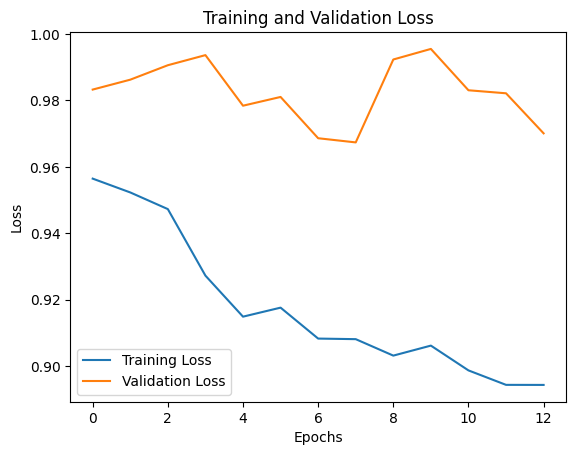

In [5]:
from model import MedicalImageCNN, CNNToRNA, train_model

from helper import collate_fn

# Create final model
model = CNNToRNA(
    cnn_encoder=MedicalImageCNN(output_dim=128),
    embedding_dim=128,
    output_dim=len(gene_names)
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Optimizer and loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training params
num_epochs = 10
batch_size = 1  # Reduce batch size to fit within memory constraints lol

# DataLoaders (make sure you use collate_fn if images are lists!)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, device
)

#construct the graph so we can visualize the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
# Save the model (for walking away lmao)
torch.save(model.state_dict(), 'model_regression.pth')

test on test test set:

In [9]:
import torch
import numpy as np
from tqdm import tqdm

def test_model(model, test_loader, device):
    model.eval()
    model.to(device)

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, _, gene_values, _ in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)
            gene_values = gene_values.to(device)

            outputs = model(images)

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(gene_values.cpu().numpy())

    preds = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return preds, targets

preds, labels = test_model(model, test_loader, device)

print("Test MSE:", mean_squared_error(labels, preds))
print("Test R² :", r2_score(labels, preds))  # Good for regression quality

Test MSE: 0.9468834400177002
Test R² : -0.04722974821925163
